In [1]:
import tensorflow as tf
import nltk
import numpy as np
import pandas as pd


In [2]:
print(tf.__version__)

2.0.0-beta0


In [4]:
train = pd.read_csv('/Users/daisy/Downloads/nyt-comments/CommentsApril2017.csv')

/anaconda3/envs/Tensorflow_test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
train.head(3)
# so it seems commentBody contains the main info

,approveDate,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,parentID,...,userLocation,userTitle,userURL,inReplyTo,articleID,sectionName,newDesk,articleWordCount,printPage,typeOfMaterial
0,1491245186,This project makes me happy to be a 30+ year T...,22022598.0,22022598,<br/>,comment,1.491237e+09,1,False,0.0,...,"Riverside, CA",NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
1,1491188619,Stunning photos and reportage. Infuriating tha...,22017350.0,22017350,NaN,comment,1.491180e+09,1,False,0.0,...,<br/>,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News
2,1491188617,Brilliant work from conception to execution. I...,22017334.0,22017334,<br/>,comment,1.491179e+09,1,False,0.0,...,Raleigh NC,NaN,NaN,0,58def1347c459f24986d7c80,Unknown,Insider,716.0,2,News


In [14]:
train['CommentBody_lower'] = train['commentBody'].str.lower() # transform it to lower case
train['CommentBody_no_punc'] = train['CommentBody_lower'].str.replace('[^\w\s]','')
print(train['commentBody'].head())
print('-----------')
print(train['CommentBody_no_punc'].head())


0    This project makes me happy to be a 30+ year T...
1    Stunning photos and reportage. Infuriating tha...
2    Brilliant work from conception to execution. I...
3    NYT reporters should provide a contributor's l...
4       Could only have been done in print. Stunning. 
Name: commentBody, dtype: object
-----------
0    this project makes me happy to be a 30 year ti...
1    stunning photos and reportage infuriating that...
2    brilliant work from conception to execution iv...
3    nyt reporters should provide a contributors li...
4         could only have been done in print stunning 
Name: CommentBody_no_punc, dtype: object


In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




In [68]:
max_length = 20
embedding_dim = 120
trunc_type = 'post'
pad_type = 'post'
oov_tok = '<OOV>'

In [69]:
corpus = Tokenizer(oov_token = oov_tok, num_words = 5000)
corpus.fit_on_texts(np.asarray(train['CommentBody_no_punc']))
training_seq = corpus.texts_to_sequences(np.asarray(train['CommentBody_no_punc']))

In [70]:
print(type(training_seq))
print(training_seq[0])

<class 'list'>
[15, 1917, 286, 82, 700, 3, 16, 6, 1033, 249, 162, 1, 365, 3, 1, 770, 34, 1, 383]


In [71]:
training_padded = pad_sequences(training_seq, truncating = trunc_type, padding = pad_type, maxlen = max_length)

In [72]:
print(training_padded[0])

[  15 1917  286   82  700    3   16    6 1033  249  162    1  365    3
    1  770   34    1  383    0]


In [73]:
print(train.columns)
print(train['recommendations'].head(), np.unique(train['recommendations'])) # according to kaggle instructions
print(train['editorsSelection'].head())
print(len(train['editorsSelection']) , sum(train['editorsSelection']))

Index(['approveDate', 'commentBody', 'commentID', 'commentSequence',
       'commentTitle', 'commentType', 'createDate', 'depth',
       'editorsSelection', 'parentID', 'parentUserDisplayName', 'permID',
       'picURL', 'recommendations', 'recommendedFlag', 'replyCount',
       'reportAbuseFlag', 'sharing', 'status', 'timespeople', 'trusted',
       'updateDate', 'userDisplayName', 'userID', 'userLocation', 'userTitle',
       'userURL', 'inReplyTo', 'articleID', 'sectionName', 'newDesk',
       'articleWordCount', 'printPage', 'typeOfMaterial', 'CommentBody_lower',
       'CommentBody_no_punc'],
      dtype='object')
0    2.0
1    1.0
2    3.0
3    7.0
4    5.0
Name: recommendations, dtype: float64 [0.000e+00 1.000e+00 2.000e+00 ... 5.671e+03 6.367e+03 7.938e+03]
0    False
1    False
2    False
3    False
4    False
Name: editorsSelection, dtype: bool
243832 5673


In [74]:
from sklearn.model_selection import train_test_split


In [75]:
x_train, x_test, y_train, y_test = train_test_split(training_padded, np.asarray(train['editorsSelection']), test_size=.2)

In [79]:
vocab_size = len(corpus.word_index)

In [81]:
print(vocab_size)

333344


In [86]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
    tf.keras.layers.Conv1D(125,5, activation = 'relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences= True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation ='relu'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(1, activation ='sigmoid')
])

In [87]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimiz = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)


In [88]:
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer = optimiz)


In [90]:
history = model.fit(x_train, y_train, callbacks = [lr_schedule], epochs= 50, validation_data = (x_test, y_test), verbose = 1)

Train on 195065 samples, validate on 48767 samples
Epoch 1/50
195065/195065 [==============================] - 937s 5ms/sample - loss: 0.6911 - accuracy: 0.7624 - val_loss: 0.6909 - val_accuracy: 0.9470
Epoch 2/50
195065/195065 [==============================] - 902s 5ms/sample - loss: 0.6906 - accuracy: 0.8116 - val_loss: 0.6904 - val_accuracy: 0.9661
Epoch 3/50
195065/195065 [==============================] - 871s 4ms/sample - loss: 0.6901 - accuracy: 0.8538 - val_loss: 0.6898 - val_accuracy: 0.9734
Epoch 4/50
195065/195065 [==============================] - 944s 5ms/sample - loss: 0.6895 - accuracy: 0.8919 - val_loss: 0.6892 - val_accuracy: 0.9758
Epoch 5/50
195065/195065 [==============================] - 1040s 5ms/sample - loss: 0.6889 - accuracy: 0.9223 - val_loss: 0.6885 - val_accuracy: 0.9760
Epoch 6/50
195065/195065 [==============================] - 985s 5ms/sample - loss: 0.6882 - accuracy: 0.9451 - val_loss: 0.6878 - val_accuracy: 0.9760
Epoch 7/50
195065/195065 [==========

<Figure size 432x288 with 0 Axes>

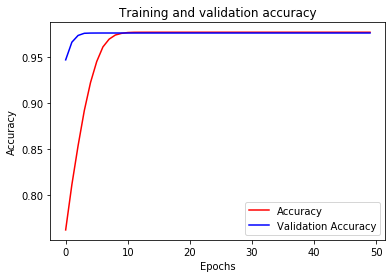

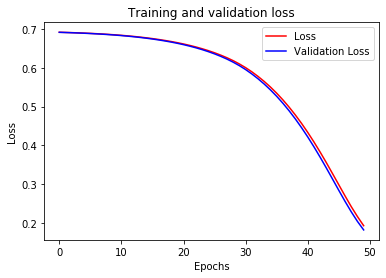

<Figure size 432x288 with 0 Axes>

In [92]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()